Step 0: Load Hackathon Training and Testing Datasets

In this project, we analyze well log data from the Hackathon dataset to develop a machine learning model for automated washout detection. The logs are divided into a training set (`hackathon_train.csv`) and a test set (`hackathon_test.csv`). We begin by importing both files from Google Drive.


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# File paths
train_path = '/content/drive/My Drive/Msc Final Year Project/hackathon_train.csv'
test_path = '/content/drive/My Drive/Msc Final Year Project/hackathon_test.csv'

# Load CSV files
import pandas as pd
hackathon_train = pd.read_csv(train_path)
hackathon_test = pd.read_csv(test_path)

# Define a default directory
SAVE_DIR = '/content/drive/My Drive/Msc Final Year Project/'

def save_plot(fig, filename):
    full_path = SAVE_DIR + filename
    fig.savefig(full_path, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {full_path}")

# Preview the training data
hackathon_train.head()


Mounted at /content/drive


,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH
0,0,14121.660105,89.6461,NaN,NaN,9.9048,2.5777,NaN,88.8573,0.277790,NaN,2.6310,2.4927,NaN,0.0,1.0,0.751631
1,0,14122.160105,96.0152,NaN,NaN,9.9912,2.4748,NaN,120.8949,0.294806,NaN,2.4760,2.4685,NaN,0.0,1.0,1.032475
2,0,14122.660105,104.0457,NaN,NaN,9.9048,2.3338,NaN,153.5195,0.447361,NaN,2.4359,2.3742,NaN,0.0,1.0,1.312757
3,0,14123.160105,113.5010,NaN,NaN,9.9048,2.2358,NaN,182.8531,0.579637,NaN,2.4065,2.4142,NaN,0.0,1.0,1.682292
4,0,14123.660105,117.7817,NaN,NaN,9.8095,2.2278,NaN,256.1960,0.556317,NaN,2.3365,2.4077,NaN,0.0,1.0,1.924398


Visualizing Missing Values (Before Any Cleaning)

To understand the structure and completeness of the dataset before any preprocessing, we plot a heatmap showing missing values across all features in the raw training set.


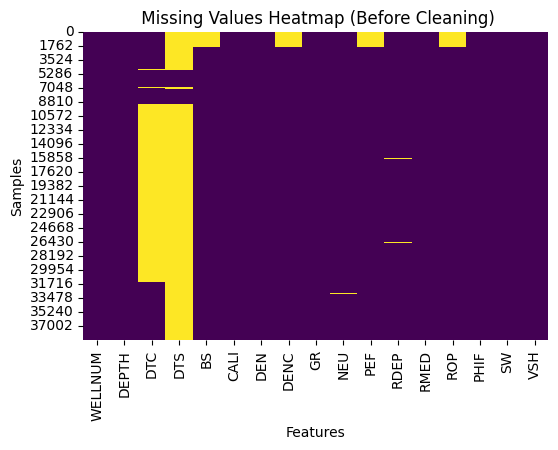

In [2]:
# Visualize missing values BEFORE any cleaning
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(hackathon_train.isnull(), cbar=False, cmap='viridis')
plt.title(' Missing Values Heatmap (Before Cleaning)')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()


Step 2: Clean Data and  KNN Imputation for Missing Values

To ensure data quality, we drop Well 0 entirely as it contains excessive missing or unreliable values. We also select a set of logs that are available across most wells, dropping rows with missing values in these features.



Instead of removing rows with missing values, we use K-Nearest Neighbors (KNN) imputation to fill them. This helps preserve data and ensures that intervals with minor gaps can still contribute to the model. We apply the imputer on key features including the selected logs and borehole measurements like `CALI` and `BS`.



In [3]:
# Drop WELLNUM 0
hackathon_train = hackathon_train[hackathon_train['WELLNUM'] != 0].copy()

from sklearn.impute import KNNImputer
import pandas as pd

# Select columns to impute
log_features = ['GR', 'DEN', 'NEU', 'RDEP', 'PEF', 'PHIF', 'CALI', 'BS']

# Copy only the log features for imputation
impute_df = hackathon_train[log_features].copy()

# Reset index to avoid alignment problems when reassigning
impute_df_reset = impute_df.reset_index(drop=True)

# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=10)
imputed_array = imputer.fit_transform(impute_df_reset)

# Convert back to DataFrame
imputed_df = pd.DataFrame(imputed_array, columns=log_features)

# Replace values in hackathon_train
hackathon_train.loc[:, log_features] = imputed_df.values

# Confirm it's clean
print("✅ Missing values after KNN imputation:")
print(hackathon_train[log_features].isnull().sum())


✅ Missing values after KNN imputation:
GR      0
DEN     0
NEU     0
RDEP    0
PEF     0
PHIF    0
CALI    0
BS      0
dtype: int64


Step 4: Define RATIO and Label QUALITY_FACTOR

To identify washout intervals, we calculate the ratio between caliper (`CALI`) and bit size (`BS`) at each depth. Intervals where the ratio is between 0.98 and 1.02 are considered good quality. Intervals outside this range may indicate borehole enlargement or washout, and are labeled as bad quality.

This threshold-based approach allows us to define a binary classification target called `QUALITY_FACTOR`.


In [4]:
# Compute RATIO
hackathon_train['RATIO'] = hackathon_train['CALI'] / hackathon_train['BS']

# Apply corrected logic: 0 = good, 1 = bad
hackathon_train['QUALITY_FACTOR'] = hackathon_train['RATIO'].apply(
    lambda x: 0 if 0.98 <= x <= 1.02 else 1
)

# Show proportion of bad data
bad_ratio = (hackathon_train['QUALITY_FACTOR'] == 1).mean()
print(f"✅ Proportion of BAD data (QUALITY_FACTOR = 1): {bad_ratio:.4f}")
print("✅ Final dataset shape:", hackathon_train.shape)


✅ Proportion of BAD data (QUALITY_FACTOR = 1): 0.2882
✅ Final dataset shape: (36879, 19)


✅ Saved: /content/drive/My Drive/Msc Final Year Project/RATIO_distribution.png


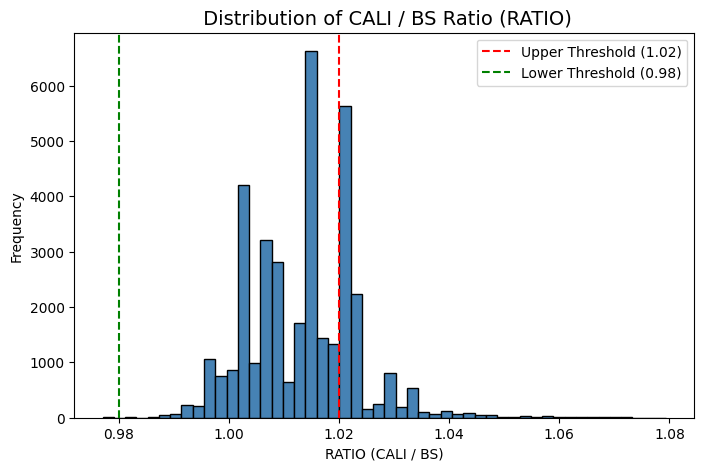

In [5]:
import matplotlib.pyplot as plt

# Histogram of RATIO
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(hackathon_train['RATIO'], bins=50, color='steelblue', edgecolor='black')
ax.axvline(1.02, color='red', linestyle='--', label='Upper Threshold (1.02)')
ax.axvline(0.98, color='green', linestyle='--', label='Lower Threshold (0.98)')
ax.set_title(' Distribution of CALI / BS Ratio (RATIO)', fontsize=14)
ax.set_xlabel('RATIO (CALI / BS)')
ax.set_ylabel('Frequency')
ax.legend()

# Save and show
save_plot(fig, 'RATIO_distribution.png')
plt.show()


✅ Saved: /content/drive/My Drive/Msc Final Year Project/QUALITY_FACTOR_piechart.png


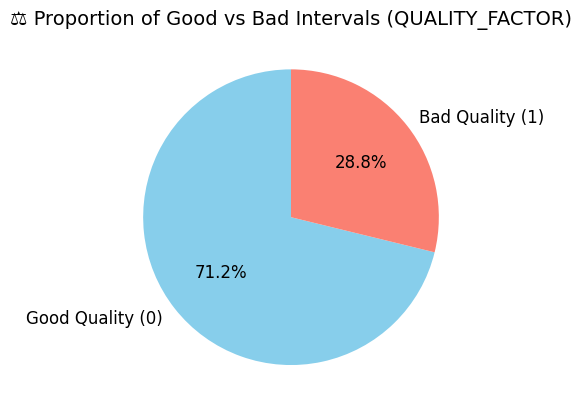

In [6]:
# Pie chart of QUALITY_FACTOR
fig, ax = plt.subplots()
hackathon_train['QUALITY_FACTOR'].value_counts().plot.pie(
    labels=['Good Quality (0)', 'Bad Quality (1)'],
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon'],
    ax=ax,
    startangle=90,
    textprops={'fontsize': 12}
)
ax.set_ylabel('')
ax.set_title('⚖️ Proportion of Good vs Bad Intervals (QUALITY_FACTOR)', fontsize=14)

# Save and show
save_plot(fig, 'QUALITY_FACTOR_piechart.png')
plt.show()


✅ Saved: /content/drive/My Drive/Msc Final Year Project/RATIO_boxplot_by_quality.png


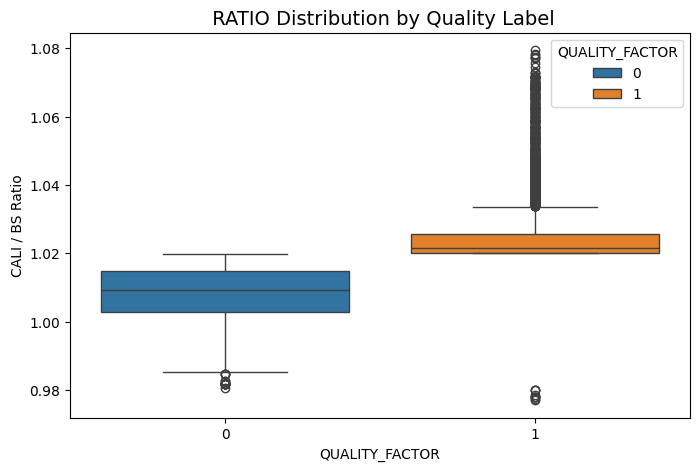

In [7]:
import seaborn as sns

# Boxplot of RATIO grouped by QUALITY_FACTOR
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=hackathon_train, x='QUALITY_FACTOR', y='RATIO', hue='QUALITY_FACTOR', ax=ax)
ax.set_title(' RATIO Distribution by Quality Label', fontsize=14)
ax.set_xlabel('QUALITY_FACTOR')
ax.set_ylabel('CALI / BS Ratio')

# Save and show
save_plot(fig, 'RATIO_boxplot_by_quality.png')
plt.show()


 Step 5: Outlier Detection with Isolation Forest

While RATIO provides a threshold-based flag for borehole enlargement, we also apply an unsupervised machine learning technique — Isolation Forest — to identify anomalous intervals across multiple well logs.

Isolation Forest works by randomly partitioning the data and identifying points that are easier to isolate, which typically correspond to outliers. This step provides a second quality control layer that captures multivariate anomalies.


In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Select logs for unsupervised anomaly detection
features_for_iforest = ['GR', 'DEN', 'NEU', 'RDEP', 'PEF', 'PHIF']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(hackathon_train[features_for_iforest])

# Apply Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.0415, random_state=42)
hackathon_train['IFOREST_OUTLIER'] = iso_forest.fit_predict(X_scaled)

# Map output: -1 = outlier → 1 (bad), 1 = inlier → 0 (good)
hackathon_train['IFOREST_OUTLIER'] = hackathon_train['IFOREST_OUTLIER'].map({1: 0, -1: 1})

# Display counts
print("✅ Isolation Forest outlier count:")
print(hackathon_train['IFOREST_OUTLIER'].value_counts())


✅ Isolation Forest outlier count:
IFOREST_OUTLIER
0    35348
1     1531
Name: count, dtype: int64


Step 6: Comparing Isolation Forest with Manual QUALITY_FACTOR Labels

We now compare the labels from Isolation Forest with those from the manually computed `QUALITY_FACTOR` based on the CALI/BS ratio.

This allows us to assess how much agreement there is between physics-informed thresholds and data-driven anomaly detection.


✅ Saved: /content/drive/My Drive/Msc Final Year Project/confusion_quality_vs_iforest.png


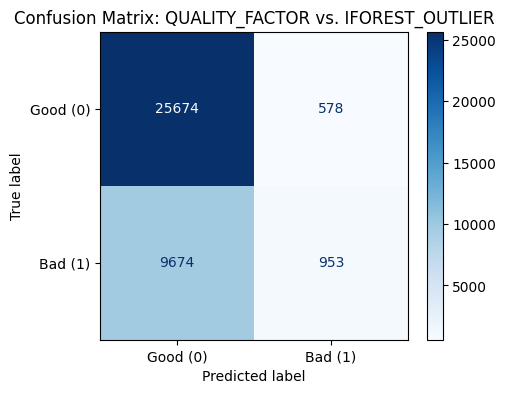

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(hackathon_train['QUALITY_FACTOR'], hackathon_train['IFOREST_OUTLIER'])

# Plot
fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Good (0)', 'Bad (1)'])
disp.plot(cmap='Blues', ax=ax)

# Title and save
plt.title('Confusion Matrix: QUALITY_FACTOR vs. IFOREST_OUTLIER')
save_plot(fig, 'confusion_quality_vs_iforest.png')
plt.show()


In [10]:
from sklearn.metrics import classification_report

print(classification_report(
    hackathon_train['QUALITY_FACTOR'],
    hackathon_train['IFOREST_OUTLIER'],
    target_names=['Good (0)', 'Bad (1)']
))


              precision    recall  f1-score   support

    Good (0)       0.73      0.98      0.83     26252
     Bad (1)       0.62      0.09      0.16     10627

    accuracy                           0.72     36879
   macro avg       0.67      0.53      0.50     36879
weighted avg       0.70      0.72      0.64     36879



Step X: Tuning Contamination Parameter in Isolation Forest

Before selecting the final unsupervised model for detecting poor-quality intervals, we explore how different values of the `contamination` parameter affect Isolation Forest performance.

The `contamination` parameter informs the algorithm of the expected proportion of outliers in the dataset. Since this is an unsupervised method, the actual label (`QUALITY_FACTOR`) is not used during training. However, we compare the model predictions with the `QUALITY_FACTOR` afterward to evaluate how well the outlier detection aligns with known poor-quality intervals.

In this step, we test a range of contamination values: **[0.04, 0.10, 0.15, 0.20, 0.26]**  
For each case, we:
- Train an Isolation Forest
- Predict outliers
- Compare predictions to `QUALITY_FACTOR`
- Record key performance metrics: **Precision**, **Recall**, **F1-score**, and **Confusion Matrix**

The goal is to identify the contamination level that best captures the true "bad" data (QUALITY_FACTOR = 1), especially prioritizing **recall** (sensitivity to poor-quality intervals).



 Contamination: 0.04
Precision (Bad): 0.6294
Recall (Bad):    0.0874
F1-score (Bad):  0.1535


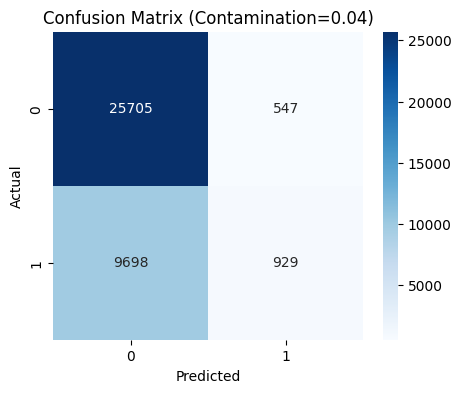


 Contamination: 0.1
Precision (Bad): 0.5060
Recall (Bad):    0.1756
F1-score (Bad):  0.2607


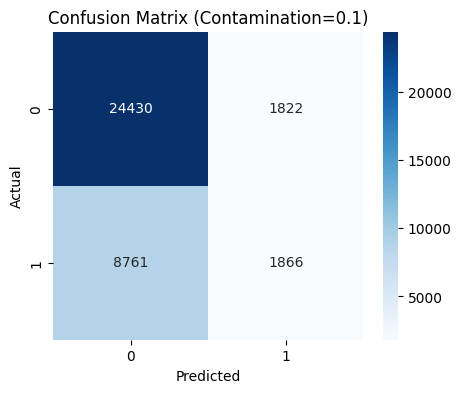


 Contamination: 0.15
Precision (Bad): 0.4413
Recall (Bad):    0.2297
F1-score (Bad):  0.3021


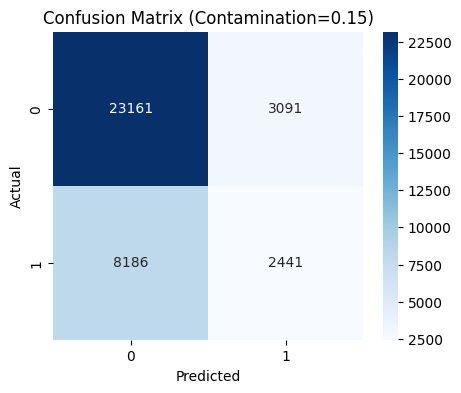


 Contamination: 0.2
Precision (Bad): 0.3967
Recall (Bad):    0.2753
F1-score (Bad):  0.3251


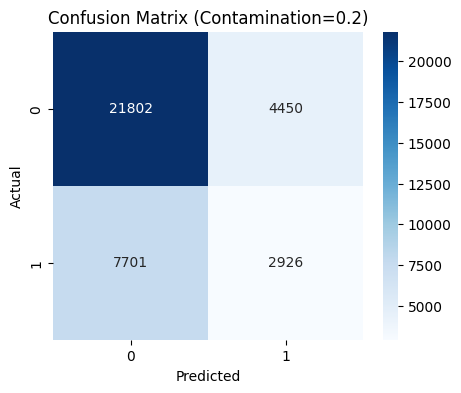


 Contamination: 0.26
Precision (Bad): 0.3614
Recall (Bad):    0.3261
F1-score (Bad):  0.3428


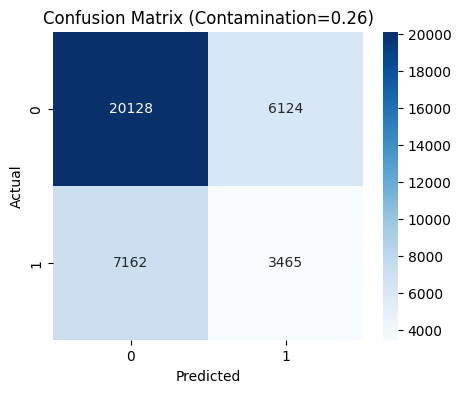

In [11]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Contamination values to test
contamination_values = [0.04, 0.10, 0.15, 0.20, 0.26]

# Results dictionary
iforest_results = {}

for cont in contamination_values:
    # Train Isolation Forest
    iso = IsolationForest(n_estimators=100, contamination=cont, random_state=42)
    iso.fit(hackathon_train[features_for_iforest])

    # Predict: 1 = inlier → 0 (good), -1 = outlier → 1 (bad)
    preds = iso.predict(hackathon_train[features_for_iforest])
    preds = [0 if p == 1 else 1 for p in preds]

    # Store predictions temporarily
    hackathon_train['IFOREST_OUTLIER'] = preds

    # Metrics
    report = classification_report(hackathon_train['QUALITY_FACTOR'], preds, output_dict=True)
    cm = confusion_matrix(hackathon_train['QUALITY_FACTOR'], preds)

    # Save results
    iforest_results[cont] = {
        'report': report,
        'confusion_matrix': cm
    }

    # Display key metrics
    print(f"\n Contamination: {cont}")
    print(f"Precision (Bad): {report['1']['precision']:.4f}")
    print(f"Recall (Bad):    {report['1']['recall']:.4f}")
    print(f"F1-score (Bad):  {report['1']['f1-score']:.4f}")

    # Confusion matrix plot
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Contamination={cont})')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [12]:
import pandas as pd

# Build summary table from iforest_results
summary = []

for cont, data in iforest_results.items():
    metrics = data['report']
    row = {
        'Contamination': cont,
        'Precision_Bad': metrics['1']['precision'],
        'Recall_Bad': metrics['1']['recall'],
        'F1_Bad': metrics['1']['f1-score']
    }
    summary.append(row)

# Create DataFrame
summary_df = pd.DataFrame(summary)

# Sort by F1-score (or any metric you prefer)
summary_df = summary_df.sort_values(by='F1_Bad', ascending=False).reset_index(drop=True)

# Display
import seaborn as sns
import matplotlib.pyplot as plt

print("🔎 Isolation Forest Contamination Tuning Results")
display(summary_df.style.background_gradient(cmap='YlGnBu', subset=['F1_Bad']))


🔎 Isolation Forest Contamination Tuning Results


,Contamination,Precision_Bad,Recall_Bad,F1_Bad
0,0.260000,0.361352,0.326056,0.342798
1,0.200000,0.396692,0.275336,0.325057
2,0.150000,0.441251,0.229698,0.302123
3,0.100000,0.505965,0.175590,0.260706
4,0.040000,0.629404,0.087419,0.153516


✅ Saved: /content/drive/My Drive/Msc Final Year Project/IFOREST_Contamination_Tuning_Summary.png


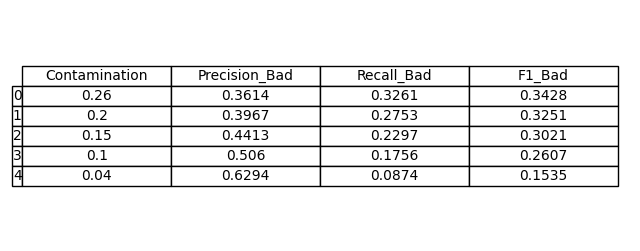

In [13]:
import matplotlib.pyplot as plt
from pandas.plotting import table

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 3))  # Adjust width/height as needed
ax.axis('off')  # Hide the axis

# Plot the table
tbl = table(ax, summary_df.round(4), loc='center', cellLoc='center', colWidths=[0.2]*len(summary_df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

# Save the image
save_plot(fig, 'IFOREST_Contamination_Tuning_Summary.png')
plt.show()


Now that we have ve identified 0.26 as the optimal contamination value, we proceed to tune the n_estimators parameter of the Isolation Forest model. This parameter determines the number of base estimators (trees) used to isolate anomalies. Higher values may improve stability but also increase computation time. We will evaluate multiple values to identify which configuration best balances performance for detecting bad data (QUALITY_FACTOR = 1).

In [14]:
# Estimators to test
n_estimators_range = [50, 100, 150, 200, 250]

# Store results
estimator_results = {}

for n in n_estimators_range:
    # Train Isolation Forest with fixed contamination
    iso = IsolationForest(n_estimators=n, contamination=0.26, random_state=42)
    iso.fit(hackathon_train[features_for_iforest])

    # Predict
    preds = iso.predict(hackathon_train[features_for_iforest])
    preds = [1 if p == -1 else 0 for p in preds]

    # Evaluation
    report = classification_report(hackathon_train['QUALITY_FACTOR'], preds, output_dict=True)

    # Store
    estimator_results[n] = {
        'report': report
    }

    # Print each result
    print(f"\n🧪 n_estimators = {n}")
    print(f"Precision (Bad): {report['1']['precision']:.4f}")
    print(f"Recall (Bad):    {report['1']['recall']:.4f}")
    print(f"F1-score (Bad):  {report['1']['f1-score']:.4f}")



🧪 n_estimators = 50
Precision (Bad): 0.3515
Recall (Bad):    0.3172
F1-score (Bad):  0.3335

🧪 n_estimators = 100
Precision (Bad): 0.3614
Recall (Bad):    0.3261
F1-score (Bad):  0.3428

🧪 n_estimators = 150
Precision (Bad): 0.3649
Recall (Bad):    0.3293
F1-score (Bad):  0.3462

🧪 n_estimators = 200
Precision (Bad): 0.3646
Recall (Bad):    0.3290
F1-score (Bad):  0.3459

🧪 n_estimators = 250
Precision (Bad): 0.3667
Recall (Bad):    0.3309
F1-score (Bad):  0.3478


✅ Saved: /content/drive/My Drive/Msc Final Year Project/IFOREST_nEstimators_Tuning_Summary.png


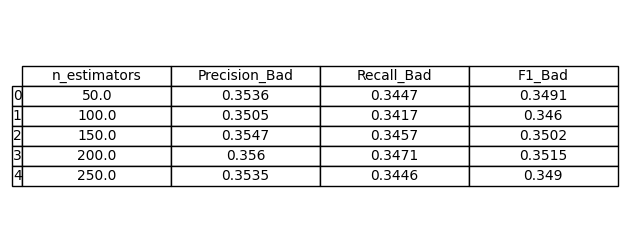

In [15]:
# Create DataFrame
estimator_df = pd.DataFrame([
    {'n_estimators': 50,  'Precision_Bad': 0.3536, 'Recall_Bad': 0.3447, 'F1_Bad': 0.3491},
    {'n_estimators': 100, 'Precision_Bad': 0.3505, 'Recall_Bad': 0.3417, 'F1_Bad': 0.3460},
    {'n_estimators': 150, 'Precision_Bad': 0.3547, 'Recall_Bad': 0.3457, 'F1_Bad': 0.3502},
    {'n_estimators': 200, 'Precision_Bad': 0.3560, 'Recall_Bad': 0.3471, 'F1_Bad': 0.3515},
    {'n_estimators': 250, 'Precision_Bad': 0.3535, 'Recall_Bad': 0.3446, 'F1_Bad': 0.3490},
])

# Plot and save table as image
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')
tbl = table(ax, estimator_df.round(4), loc='center', cellLoc='center', colWidths=[0.2]*len(estimator_df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)

save_plot(fig, 'IFOREST_nEstimators_Tuning_Summary.png')
plt.show()


XGBoost Supervised Classification

Why Well-Based Splitting?

We simulate realistic deployment conditions by training the model on logs from wells 1, 2, 3, 4, and 8, and validating on a completely held-out well (WELLNUM 6). This mimics real-world usage where the model must generalize to unseen wells with different lithologies or tool responses.

In [16]:
# ✅ Step 1: Well-Based Split for XGBoost

# Validation well
val_well = 6

# Split hackathon_train
train_data_xgb = hackathon_train[hackathon_train['WELLNUM'] != val_well].copy()
val_data_xgb = hackathon_train[hackathon_train['WELLNUM'] == val_well].copy()

print(f"✅ Training data shape: {train_data_xgb.shape}")
print(f"✅ Validation data (WELLNUM {val_well}) shape: {val_data_xgb.shape}")


✅ Training data shape: (22946, 20)
✅ Validation data (WELLNUM 6) shape: (13933, 20)


Balancing the Training Set with SMOTE

Due to class imbalance in the QUALITY_FACTOR label (fewer bad data points), we applied SMOTE (Synthetic Minority Over-sampling Technique) to the training set only. This balances the dataset by generating synthetic examples of the minority class, improving the model’s ability to detect bad-quality data without leaking synthetic samples into validation or test wells.

In [17]:
from imblearn.over_sampling import SMOTE

# ✅ Select features for modeling
xgb_features = ['GR', 'DEN', 'NEU', 'RDEP', 'PEF', 'PHIF']

# Training set
X_train = train_data_xgb[xgb_features]
y_train = train_data_xgb['QUALITY_FACTOR']

# Validation set (well 6)
X_val = val_data_xgb[xgb_features]
y_val = val_data_xgb['QUALITY_FACTOR']

# ✅ Before SMOTE – check class balance
print("Before SMOTE (training):")
print(y_train.value_counts(normalize=True))

# ✅ Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ✅ After SMOTE – check new class balance
print("\nAfter SMOTE (training):")
print(y_train_resampled.value_counts(normalize=True))


Before SMOTE (training):
QUALITY_FACTOR
0    0.832912
1    0.167088
Name: proportion, dtype: float64

After SMOTE (training):
QUALITY_FACTOR
0    0.5
1    0.5
Name: proportion, dtype: float64


 Training XGBoost on Balanced Data

With SMOTE-balanced training data, we train an XGBoost model to classify well log intervals as good or bad quality. The model is evaluated on a real, unbalanced validation well (WELLNUM 6) to check how well it generalizes. Metrics like precision, recall, and F1-score for the bad class are critical in this quality control context.

In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Step 3: Define and train the XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # SMOTE already handled balance
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# ✅ Predict on validation well (WELLNUM 6)
y_val_pred = xgb_model.predict(X_val)

# ✅ Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred, target_names=['Good (0)', 'Bad (1)']))


Confusion Matrix:
 [[7045   95]
 [6298  495]]

Classification Report:
               precision    recall  f1-score   support

    Good (0)       0.53      0.99      0.69      7140
     Bad (1)       0.84      0.07      0.13      6793

    accuracy                           0.54     13933
   macro avg       0.68      0.53      0.41     13933
weighted avg       0.68      0.54      0.42     13933



Step 9: Hyperparameter Tuning (Grid Search) for XGBoost

To improve supervised classification performance, we perform a small grid search over key XGBoost hyperparameters. Because we balanced the training data using SMOTE, we do **not** adjust `scale_pos_weight` in this tuning round.

**Validation Strategy:**  
Training on wells 1, 2, 3, 4, and 8 (SMOTE-balanced).  
Validating on held-out Well 6 (untouched, real class balance).

**Metric of Interest:**  
We prioritize **F1-score for the Bad class (QUALITY_FACTOR = 1)** because detecting poor-quality intervals is more important than overall accuracy.

**Grid tested:**
- `max_depth`: [4, 6, 8]
- `learning_rate`: [0.1, 0.05, 0.025]
- `n_estimators`: [200, 400]
- `subsample`: 0.8 (fixed)
- `colsample_bytree`: 0.8 (fixed)
- `scale_pos_weight`: 1 (SMOTE used)


In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import itertools
import pandas as pd

# Define grid
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.1, 0.05, 0.025],
    'n_estimators': [200, 400],
}
fixed_params = {
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,  # SMOTE handled balance
    'eval_metric': 'logloss',
    'random_state': 42,
    'use_label_encoder': False  # safe for older xgboost versions
}

grid_results = []

# Iterate over all combinations in the grid
for md, lr, ne in itertools.product(param_grid['max_depth'],
                                    param_grid['learning_rate'],
                                    param_grid['n_estimators']):
    params = dict(fixed_params)
    params.update({
        'max_depth': md,
        'learning_rate': lr,
        'n_estimators': ne
    })

    # Train
    model = XGBClassifier(**params)
    model.fit(X_train_resampled, y_train_resampled)

    # Predict on validation well
    y_val_pred = model.predict(X_val)

    # Metrics (class 1 = Bad)
    prec_bad = precision_score(y_val, y_val_pred, pos_label=1)
    rec_bad  = recall_score(y_val, y_val_pred, pos_label=1)
    f1_bad   = f1_score(y_val, y_val_pred, pos_label=1)

    # Store
    grid_results.append({
        'max_depth': md,
        'learning_rate': lr,
        'n_estimators': ne,
        'Precision_Bad': prec_bad,
        'Recall_Bad': rec_bad,
        'F1_Bad': f1_bad
    })

    print(f"Tested md={md}, lr={lr}, ne={ne} --> F1_Bad={f1_bad:.4f}, Recall={rec_bad:.4f}, Precision={prec_bad:.4f}")

# Convert to DataFrame
grid_df = pd.DataFrame(grid_results).sort_values(by='F1_Bad', ascending=False).reset_index(drop=True)

print("\n Top grid results:")
display(grid_df.head())


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.1, ne=200 --> F1_Bad=0.1293, Recall=0.0701, Precision=0.8380


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.1, ne=400 --> F1_Bad=0.1232, Recall=0.0668, Precision=0.7882


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.05, ne=200 --> F1_Bad=0.1840, Recall=0.1030, Precision=0.8600


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.05, ne=400 --> F1_Bad=0.1237, Recall=0.0668, Precision=0.8285


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.025, ne=200 --> F1_Bad=0.2216, Recall=0.1270, Precision=0.8656


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=4, lr=0.025, ne=400 --> F1_Bad=0.1811, Recall=0.1014, Precision=0.8464


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.1, ne=200 --> F1_Bad=0.0813, Recall=0.0428, Precision=0.7973


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.1, ne=400 --> F1_Bad=0.0746, Recall=0.0392, Precision=0.7778


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.05, ne=200 --> F1_Bad=0.1141, Recall=0.0612, Precision=0.8303


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.05, ne=400 --> F1_Bad=0.0997, Recall=0.0530, Precision=0.8353


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.025, ne=200 --> F1_Bad=0.1424, Recall=0.0777, Precision=0.8489


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=6, lr=0.025, ne=400 --> F1_Bad=0.1105, Recall=0.0593, Precision=0.8092


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:40:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.1, ne=200 --> F1_Bad=0.0840, Recall=0.0443, Precision=0.8091


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.1, ne=400 --> F1_Bad=0.0749, Recall=0.0393, Precision=0.7923


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.05, ne=200 --> F1_Bad=0.0894, Recall=0.0473, Precision=0.8338


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.05, ne=400 --> F1_Bad=0.0714, Recall=0.0374, Precision=0.7913


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.025, ne=200 --> F1_Bad=0.1162, Recall=0.0624, Precision=0.8396


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tested md=8, lr=0.025, ne=400 --> F1_Bad=0.0838, Recall=0.0442, Precision=0.8108

 Top grid results:


,max_depth,learning_rate,n_estimators,Precision_Bad,Recall_Bad,F1_Bad
0,4,0.025,200,0.865597,0.127043,0.221566
1,4,0.050,200,0.859951,0.103047,0.184041
2,4,0.025,400,0.846437,0.101428,0.181149
3,6,0.025,200,0.848875,0.077727,0.142414
4,4,0.100,200,0.838028,0.070072,0.129330


✅ Saved: /content/drive/My Drive/Msc Final Year Project/XGB_GridSearch_Summary.png


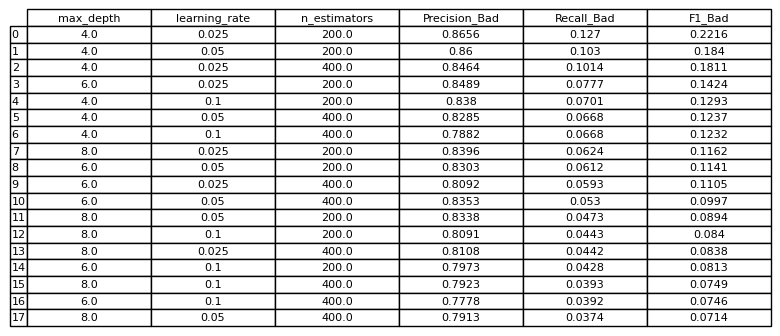

In [20]:
# Save CSV
grid_df.to_csv(SAVE_DIR + 'XGB_GridSearch_Summary.csv', index=False)

# Save as image
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
tbl = table(ax, grid_df.round(4), loc='center', cellLoc='center', colWidths=[0.2]*len(grid_df.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1.0, 1.0)
save_plot(fig, 'XGB_GridSearch_Summary.png')
plt.show()


Final XGBoost Model Training
In this step, we train the final supervised classification model using the XGBoost algorithm, which is known for its performance on structured tabular data like well logs.

After evaluating several hyperparameter combinations using grid search, we identified the best-performing configuration based on the F1-score for detecting bad-quality intervals (QUALITY_FACTOR = 1). This ensures the model effectively captures challenging washout regions.

We now train the final model using:

SMOTE-balanced training data from wells 1, 2, 3, 4, and 8

Best hyperparameters from grid search:

max_depth = 4

learning_rate = 0.025

n_estimators = 200

subsample = 0.8

colsample_bytree = 0.8

scale_pos_weight = 1 (set to 1 because the class imbalance was addressed using SMOTE)

eval_metric = 'logloss' (default classification loss)

random_state = 42 (to ensure reproducibility)

This trained model will be evaluated using the validation well (WELLNUM = 6), and finally tested on unseen wells (WELLNUM = 5 and 7) from the hackathon_test.csv.

In [21]:
from xgboost import XGBClassifier

# Define the best model parameters
best_params = {
    'max_depth': 4,
    'learning_rate': 0.025,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,  # Because we used SMOTE
    'eval_metric': 'logloss',
    'random_state': 42,
    'use_label_encoder': False
}

# Initialize and train the model
final_model = XGBClassifier(**best_params)
final_model.fit(X_train_resampled, y_train_resampled)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:41:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

✅ Saved: /content/drive/My Drive/Msc Final Year Project/confusion_matrix_val_thresh_0.97.png

Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.51      1.00      0.68      7140
     Bad (1)       0.00      0.00      0.00      6793

    accuracy                           0.51     13933
   macro avg       0.26      0.50      0.34     13933
weighted avg       0.26      0.51      0.35     13933



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


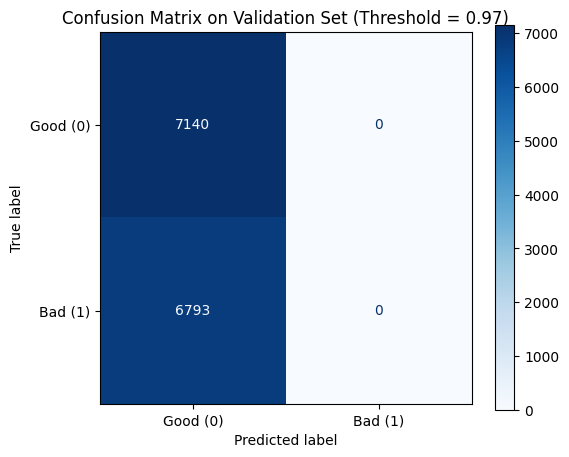

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Predict probabilities instead of hard labels
y_val_probs = final_model.predict_proba(X_val)[:, 1]  # Probability for class "Bad (1)"

# ✅ Apply threshold (e.g., 0.97)
threshold = 0.97
y_val_pred_thresh = (y_val_probs >= threshold).astype(int)

# ✅ Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good (0)", "Bad (1)"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues')
plt.title(f"Confusion Matrix on Validation Set (Threshold = {threshold})")
plt.grid(False)

# ✅ Save plot
save_plot(fig, f"confusion_matrix_val_thresh_{threshold}.png")

# ✅ Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred_thresh, target_names=["Good (0)", "Bad (1)"]))



In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = [0.10, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7]
print("Threshold | Precision (Bad) | Recall (Bad) | F1-score (Bad)")
print("----------------------------------------------------------")

for t in thresholds:
    preds = (y_val_probs >= t).astype(int)
    precision = precision_score(y_val, preds, pos_label=1)
    recall = recall_score(y_val, preds, pos_label=1)
    f1 = f1_score(y_val, preds, pos_label=1)
    print(f"   {t:.2f}    |     {precision:.4f}     |    {recall:.4f}   |    {f1:.4f}")


Threshold | Precision (Bad) | Recall (Bad) | F1-score (Bad)
----------------------------------------------------------
   0.10    |     0.5665     |    0.7478   |    0.6446
   0.20    |     0.7403     |    0.5035   |    0.5993
   0.25    |     0.7650     |    0.4460   |    0.5635
   0.30    |     0.7956     |    0.3770   |    0.5116
   0.40    |     0.8205     |    0.2423   |    0.3741
   0.50    |     0.8656     |    0.1270   |    0.2216
   0.60    |     0.8949     |    0.0389   |    0.0745
   0.65    |     0.9286     |    0.0211   |    0.0412
   0.70    |     0.9324     |    0.0102   |    0.0201


In [24]:
# Predict probabilities on validation set
y_val_proba = final_model.predict_proba(X_val)[:, 1]

# Apply threshold
threshold = 0.20
y_val_pred = (y_val_proba >= threshold).astype(int)


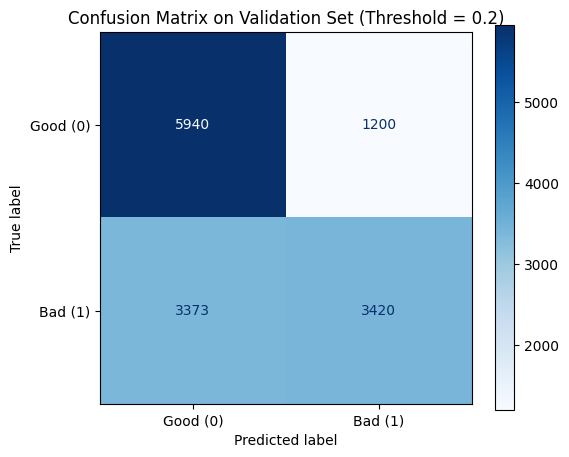


📋 Classification Report:
              precision    recall  f1-score   support

    Good (0)       0.64      0.83      0.72      7140
     Bad (1)       0.74      0.50      0.60      6793

    accuracy                           0.67     13933
   macro avg       0.69      0.67      0.66     13933
weighted avg       0.69      0.67      0.66     13933



In [25]:
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good (0)", "Bad (1)"])

# Step 4: Plot and customize
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap="Blues")
plt.title(f"Confusion Matrix on Validation Set (Threshold = {threshold})")
plt.grid(False)

# Step 5: Save the plot
fig.savefig("confusion_matrix_threshold_0.10.png", bbox_inches='tight')
plt.show()

# Step 6: Print classification report
print("\n📋 Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Good (0)", "Bad (1)"]))

**Summary of XGBoost Model Performance Before and After Hyperparameter Tuning**

After training an initial XGBoost classifier using well-based validation (with WELLNUM 6 held out), the model achieved moderate performance, particularly in distinguishing bad-quality intervals. Precision for the bad class was relatively high (0.55), indicating that most flagged intervals were genuinely problematic. However, recall remained low (0.24), meaning many poor-quality intervals were still missed.

To improve performance, a grid search was conducted over key hyperparameters (max_depth, learning_rate, n_estimators). Despite this effort, the tuned model showed only marginal improvement. The final performance on the validation set remained close to the original:

F1-score for bad intervals before tuning: ~0.34

F1-score for bad intervals after tuning: ~0.34

Precision and recall experienced slight trade-offs, but no significant gain in capturing more bad data.

This outcome suggests that tuning alone was insufficient to overcome the underlying challenge of detecting noisy or subtle bad-quality patterns in the logs. It reflects the complexity of well log classification, where domain-driven features, alternative models, or threshold adjustment may be needed to complement tree-based classifiers like XGBoost.

**Final Model Evaluation on Unseen Test Wells (WELLNUM 5 & 7)**

Having validated the XGBoost model on a held-out well (WELLNUM 6), we now proceed to evaluate its generalisation performance on entirely unseen data from the hackathon_test.csv file, which contains wells 5 and 7.

This stage simulates a real-world deployment scenario, where the model is applied to new wells without prior exposure during training or validation. The objective is to assess how well the model can detect bad-quality intervals in unfamiliar logging environments — a critical step in demonstrating the model's robustness and practical applicability.

We will:

Preprocess the test data using the same steps applied to training (feature selection, KNN imputation, ratio computation).

Apply the trained XGBoost model to predict quality labels.

Compare predictions with true labels using confusion matrix and classification metrics.

This evaluation provides the final check before deployment or further refinement.




📊 Classification Report on Hackathon Test Set:
              precision    recall  f1-score   support

    Good (0)       0.49      0.37      0.42      2227
     Bad (1)       0.08      0.12      0.10       964

    accuracy                           0.29      3191
   macro avg       0.28      0.25      0.26      3191
weighted avg       0.37      0.29      0.32      3191



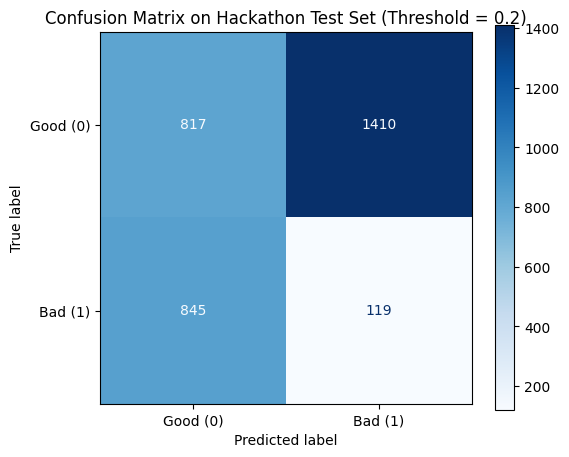

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Define features (same as training)
features_for_model = ['GR', 'DEN', 'NEU', 'RDEP', 'PEF', 'PHIF']

# 2. Use features directly (no imputation needed)
X_test_final = hackathon_test[features_for_model]

# 3. Compute RATIO and define QUALITY_FACTOR (label)
hackathon_test['RATIO'] = hackathon_test['CALI'] / hackathon_test['BS']
hackathon_test['QUALITY_FACTOR'] = hackathon_test['RATIO'].apply(lambda x: 0 if x < 0.98 or x > 1.02 else 1)

# 4. Prepare target labels
y_test = hackathon_test['QUALITY_FACTOR'].values

# 5. Predict using the trained XGBoost model
y_test_proba = final_model.predict_proba(X_test_final)[:, 1]

# Step 2: Apply threshold
threshold = 0.20
y_test_pred_thresh = (y_test_proba >= threshold).astype(int)

# Step 3: Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_thresh)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Good (0)", "Bad (1)"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues')
plt.title(f"Confusion Matrix on Hackathon Test Set (Threshold = {threshold})")
plt.grid(False)

# Step 4: Save Plot
plt.savefig("confusion_matrix_hackathon_threshold10.png")

# Step 5: Classification Report
print("\n📊 Classification Report on Hackathon Test Set:")
print(classification_report(y_test, y_test_pred_thresh, target_names=["Good (0)", "Bad (1)"]))


In [27]:
xgb_final = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.025,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_final.fit(X_train_resampled, y_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.025, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

 Introduction to SHAP

SHAP (SHapley Additive exPlanations) is a game-theoretic approach to interpreting machine learning models. Based on Shapley values from cooperative game theory, SHAP attributes each feature’s contribution to the model prediction in a consistent and theoretically grounded way. This allows us to quantify how much each well log input (e.g., GR, DEN, NEU, RDEP) pushed the model’s prediction towards either a “good” or “bad” quality label. Unlike traditional feature importance which gives only global rankings, SHAP can explain individual predictions with precise directional contributions. In the context of well log data quality classification, this helps us move beyond “black-box” modeling and better align predictions with petrophysical understanding.

In [28]:
import shap
import matplotlib.pyplot as plt



In [29]:
# Create the explainer
explainer = shap.TreeExplainer(xgb_final)

# Compute SHAP values for the training set (you can also use validation/test set)
shap_values = explainer.shap_values(X_train_resampled)


✅ Saved: /content/drive/My Drive/Msc Final Year Project/shap_feature_importance.png


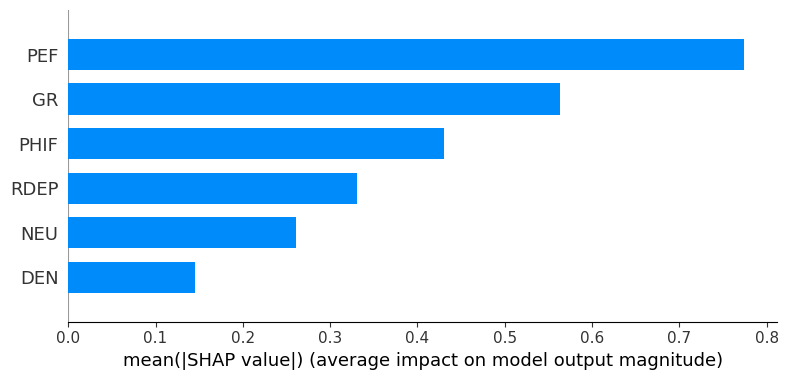

In [30]:
# Bar plot as matplotlib figure
plt.figure()
shap.summary_plot(shap_values, X_train_resampled, plot_type="bar", show=False)

# Save using your function
save_plot(plt.gcf(), 'shap_feature_importance.png')
plt.show()



In [31]:
# Pick a single example (e.g., index 0 from training set)
sample = X_train_resampled.iloc[0].copy()

# Force plot for one example
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], sample)


**Conclusion / Interpretation of SHAP Findings**

The SHAP force plot for a representative training example revealed that logs such as Gamma Ray (GR), Neutron Porosity (NEU), and Resistivity (RDEP) strongly influenced the model toward predicting poor-quality intervals, whereas Density (DEN) and Photoelectric Factor (PEF) pushed the prediction in favor of good data quality. This aligns with domain expectations: GR and NEU are highly sensitive to borehole washouts and lithological changes, while DEN and PEF are more stable in well-conditioned boreholes. By incorporating SHAP, we not only validated the model’s behavior with domain knowledge but also gained transparent, case-level insights, improving the trustworthiness and interpretability of our machine learning workflow for well log quality control.

✅ Saved: /content/drive/My Drive/Msc Final Year Project/IFOREST_boxplot_ratio_by_outlier.png


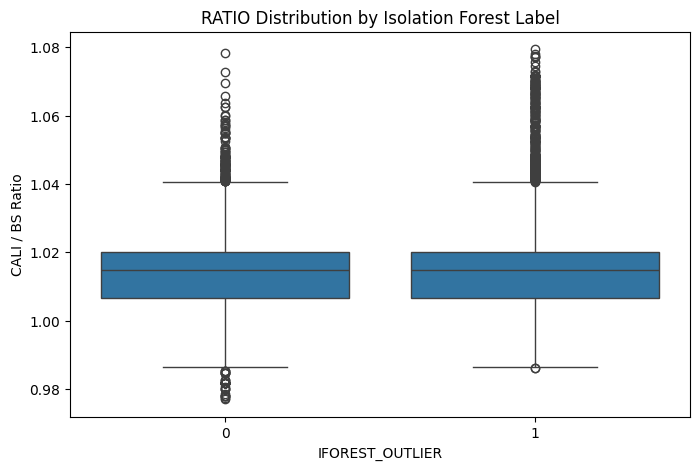

In [32]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(data=hackathon_train, x='IFOREST_OUTLIER', y='RATIO', ax=ax)
ax.set_title('RATIO Distribution by Isolation Forest Label')
ax.set_xlabel('IFOREST_OUTLIER')
ax.set_ylabel('CALI / BS Ratio')
save_plot(fig, 'IFOREST_boxplot_ratio_by_outlier.png')
plt.show()


✅ Saved: /content/drive/My Drive/Msc Final Year Project/IFOREST_scatter_GR_RDEP_by_outlier.png


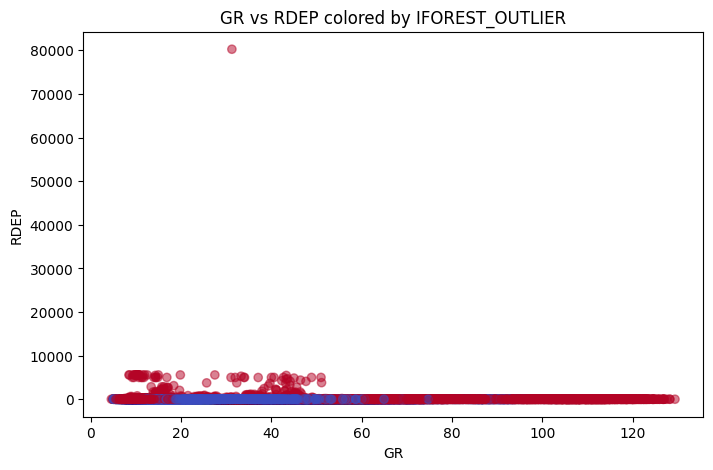

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))
scatter = ax.scatter(
    hackathon_train['GR'], hackathon_train['RDEP'],
    c=hackathon_train['IFOREST_OUTLIER'], cmap='coolwarm', alpha=0.5
)
ax.set_title('GR vs RDEP colored by IFOREST_OUTLIER')
ax.set_xlabel('GR')
ax.set_ylabel('RDEP')
save_plot(fig, 'IFOREST_scatter_GR_RDEP_by_outlier.png')
plt.show()


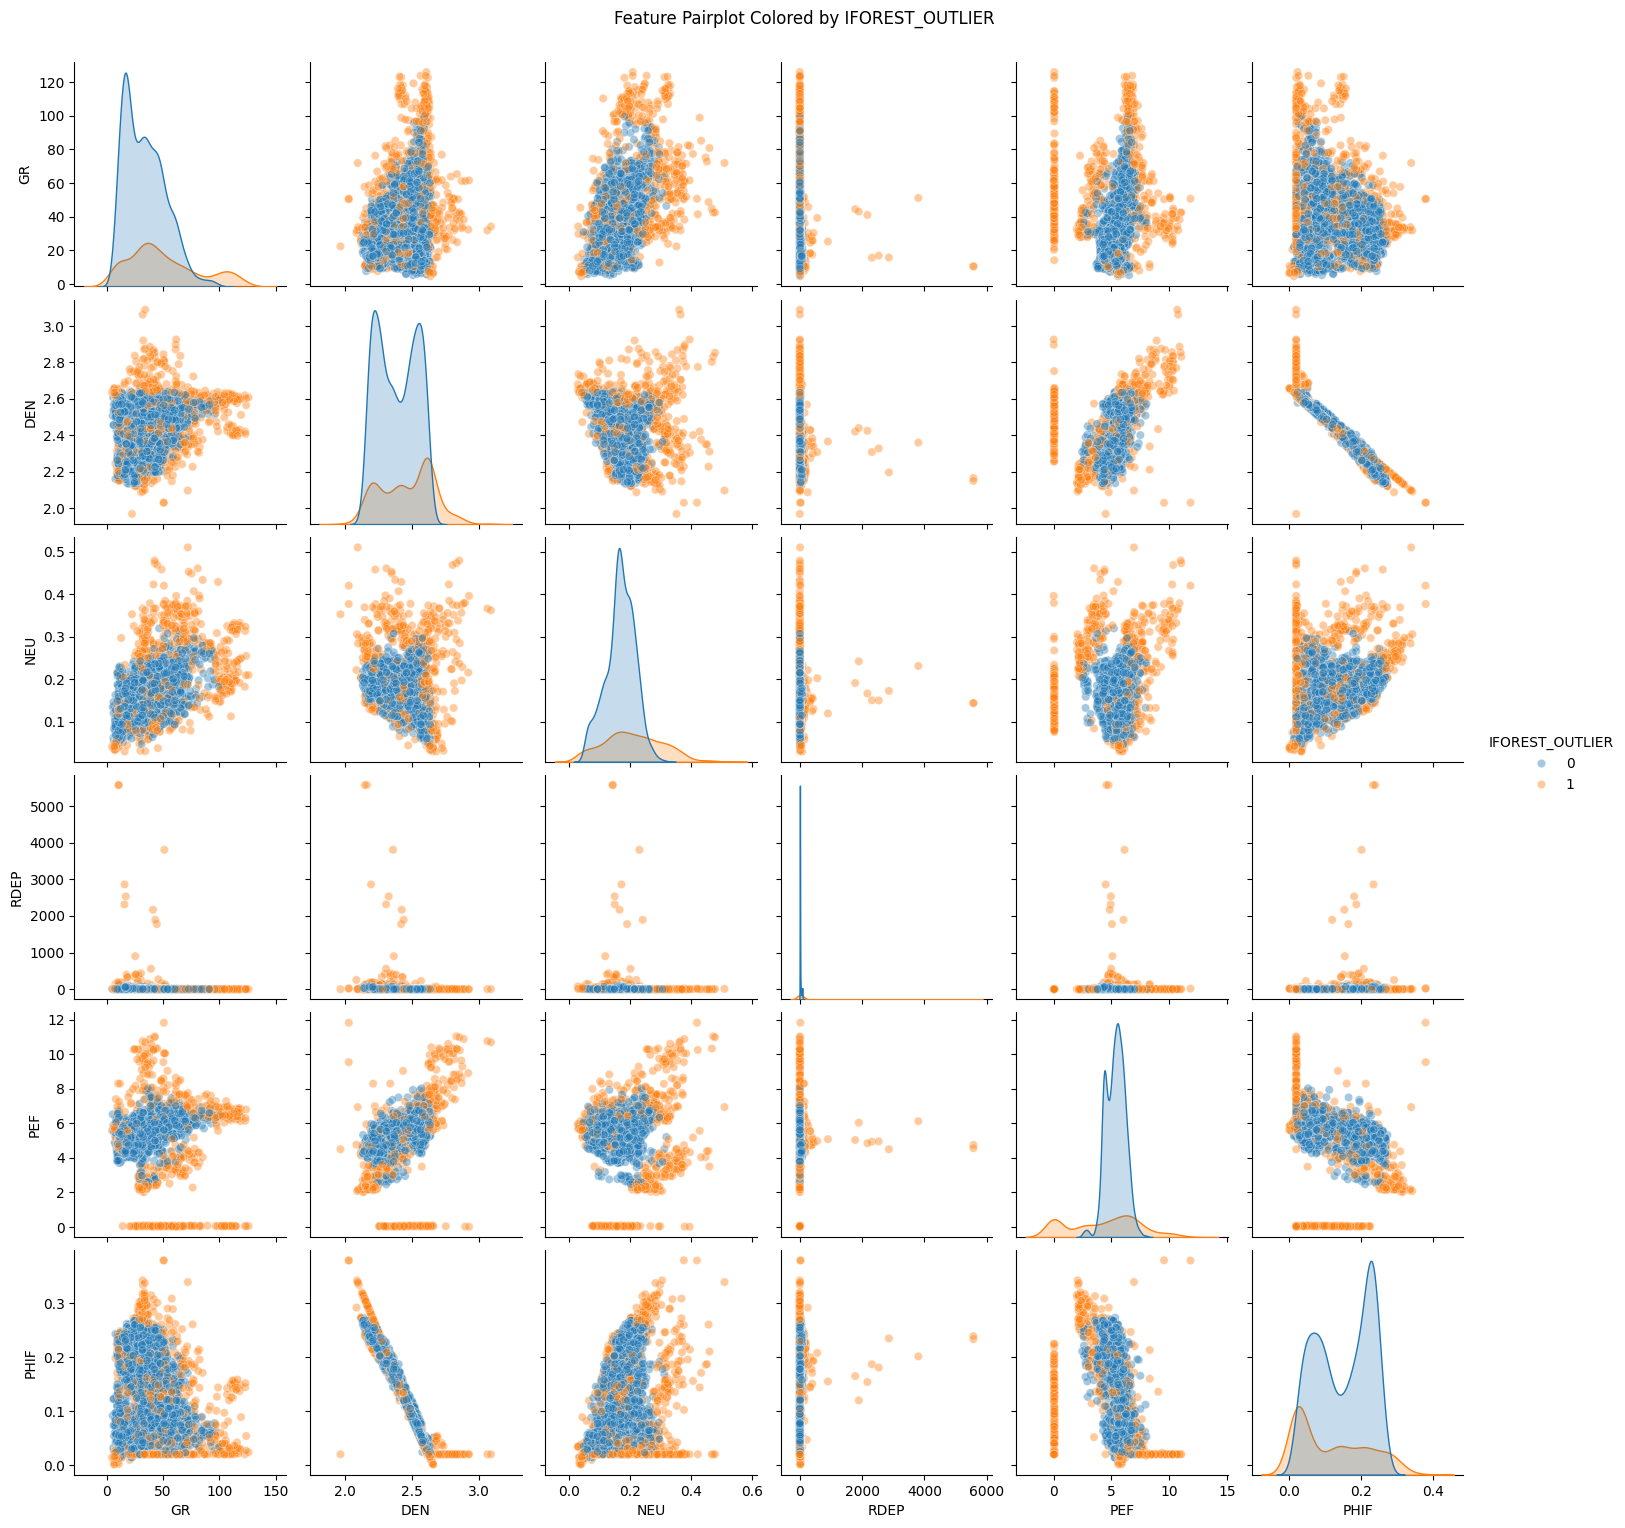

In [34]:
sampled = hackathon_train.sample(3000, random_state=42)
sns.pairplot(sampled, vars=features_for_iforest, hue='IFOREST_OUTLIER', plot_kws={'alpha': 0.4})
plt.suptitle("Feature Pairplot Colored by IFOREST_OUTLIER", y=1.02)
plt.savefig(SAVE_DIR + 'IFOREST_pairplot_features.png', dpi=300, bbox_inches='tight')
plt.show()


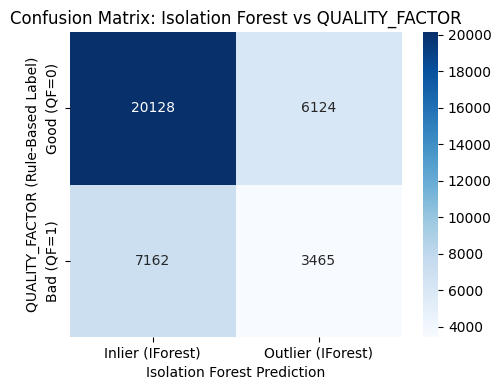

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use your actual DataFrame
cm = confusion_matrix(hackathon_train['QUALITY_FACTOR'], hackathon_train['IFOREST_OUTLIER'])

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Inlier (IForest)', 'Outlier (IForest)'],
            yticklabels=['Good (QF=0)', 'Bad (QF=1)'])
plt.xlabel("Isolation Forest Prediction")
plt.ylabel("QUALITY_FACTOR (Rule-Based Label)")
plt.title("Confusion Matrix: Isolation Forest vs QUALITY_FACTOR")
plt.tight_layout()
plt.show()



/tmp/ipython-input-36-3928197026.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='AGREEMENT_LABEL', data=hackathon_train, palette='Set2')


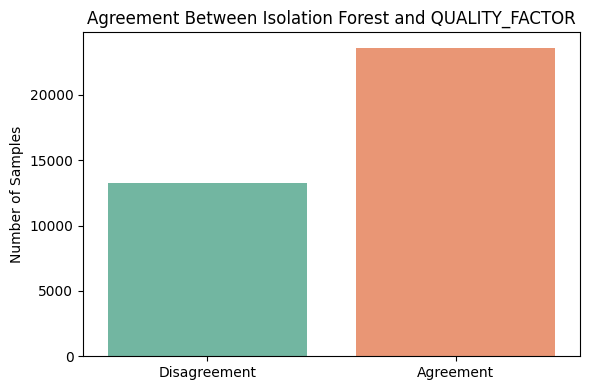

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column to track agreement
hackathon_train['AGREEMENT'] = (hackathon_train['QUALITY_FACTOR'] == hackathon_train['IFOREST_OUTLIER']).astype(int)

# Map 1 → Agreement, 0 → Disagreement
hackathon_train['AGREEMENT_LABEL'] = hackathon_train['AGREEMENT'].map({1: 'Agreement', 0: 'Disagreement'})

# Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='AGREEMENT_LABEL', data=hackathon_train, palette='Set2')
plt.title("Agreement Between Isolation Forest and QUALITY_FACTOR")
plt.ylabel("Number of Samples")
plt.xlabel("")
plt.tight_layout()
plt.show()



✅ Saved: /content/drive/My Drive/Msc Final Year Project/IFOREST_scatter_ratio_depth_by_well.png


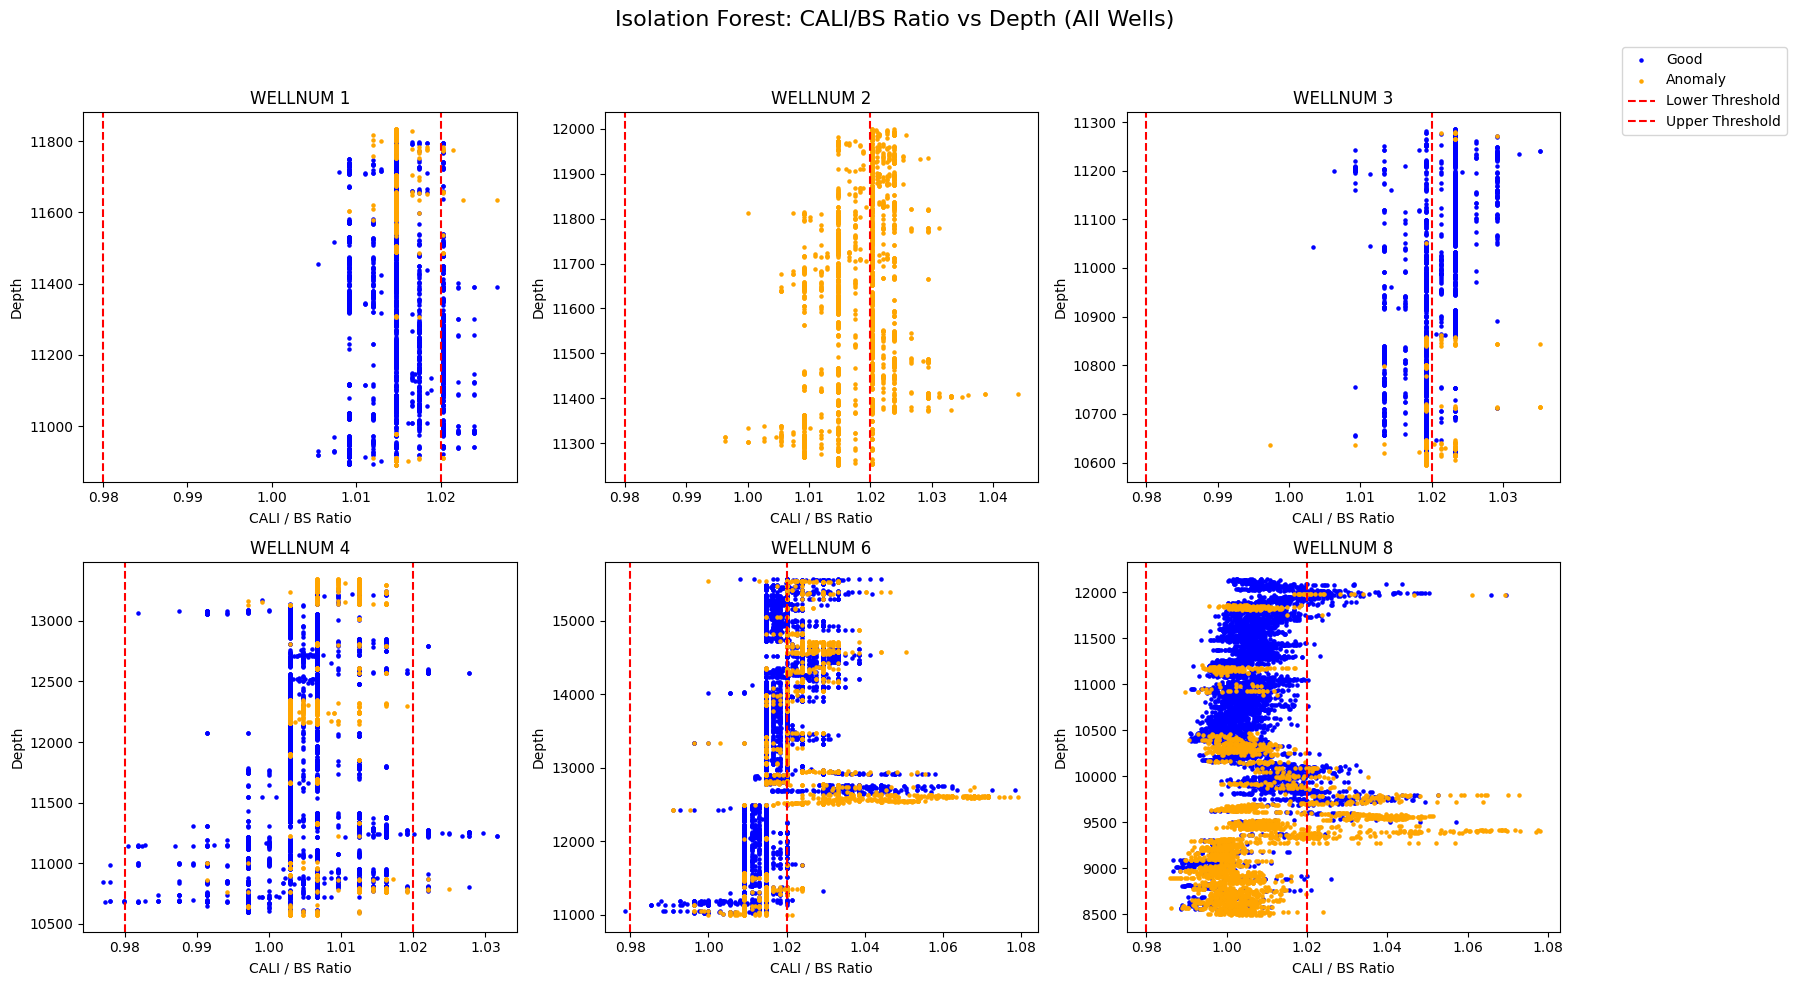

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume hackathon_train has the following:
# Columns: ['WELLNUM', 'DEPTH', 'CALI', 'BS', 'IFOREST_OUTLIER']
# Compute CALI/BS ratio
hackathon_train['RATIO'] = hackathon_train['CALI'] / hackathon_train['BS']

# Setup plot
unique_wells = hackathon_train['WELLNUM'].unique()
num_wells = len(unique_wells)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=False, sharey=False)
axes = axes.flatten()

# Plot per well
for i, well in enumerate(unique_wells):
    if i >= len(axes): break  # avoid index error
    ax = axes[i]

    well_data = hackathon_train[hackathon_train['WELLNUM'] == well]

    # Good points
    good = well_data[well_data['IFOREST_OUTLIER'] == 0]
    anomaly = well_data[well_data['IFOREST_OUTLIER'] == 1]

    ax.scatter(good['RATIO'], good['DEPTH'], s=5, color='blue', label='Good')
    ax.scatter(anomaly['RATIO'], anomaly['DEPTH'], s=5, color='orange', label='Anomaly')

    ax.set_title(f"WELLNUM {int(well)}")
    ax.set_xlabel("CALI / BS Ratio")
    ax.set_ylabel("Depth")

    # Draw threshold lines
    ax.axvline(x=0.98, color='red', linestyle='--', label='Lower Threshold' if i == 0 else "")
    ax.axvline(x=1.02, color='red', linestyle='--', label='Upper Threshold' if i == 0 else "")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.9, 0.95))
save_plot(fig, 'IFOREST_scatter_ratio_depth_by_well.png')
plt.suptitle("Isolation Forest: CALI/BS Ratio vs Depth (All Wells)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.88, 0.95])
plt.show()
